# 识别计算跳跃收益

## 导入模块

In [87]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import feather
import math
from scipy import stats
from tqdm.notebook import tqdm
import os
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


## 读入测试数据

In [88]:
price_1m = feather.read_dataframe('../data/StockPriceK1m/2024/StockPriceK1m_20240102.feather')
price_1m['date'] = pd.to_datetime(price_1m['date'].astype(str))
price_1d = feather.read_dataframe('../data/StockPriceK1d_20241231.feather')
price_1d['date'] = pd.to_datetime(price_1d['date'])

## 处理筛选日线数据

剔除上市不足 180 天、停牌、涨停股票

In [89]:
# def IPO_time(price_1d, timedelta='180D'):
#     start_date = price_1d['date'].min()
#     idx_ipo = price_1d['date'] >= start_date + pd.Timedelta(timedelta)
#     return price_1d[idx_ipo]

# price_1d = price_1d.groupby('issue').apply(IPO_time)
# price_1d = price_1d[(~price_1d['is_limit_buy'].astype(bool)) & (~price_1d['is_limit_sell'].astype(bool))]

In [90]:
idx_date = (price_1d['date'] >= '2019-01-01') & (price_1d['date'] <= '2024-12-31')
price_1d = price_1d[idx_date]
price_1d = price_1d.set_index(['issue', 'date'])

## 定义跳跃统计量

In [91]:
def mu(p: float):
    return (2 ** (p / 2)) * math.gamma((p + 1) / 2) / np.sqrt(np.pi)

mu1 = mu(1)
mu6 = mu(6)

def JS(ret, log_ret):
    n_series, n_points = ret.shape
    abs_log_ret = np.abs(log_ret)
    
    window_size = 6
    windows = np.lib.stride_tricks.sliding_window_view(
        abs_log_ret, window_shape=window_size, axis=1
    )
    prod_6 = np.prod(windows, axis=-1)
    sum_prod_6 = np.sum(prod_6, axis=1)
    coef_Omega = (mu6 / 9) * ((n_points ** 3) * (mu1 ** -6) / (n_points - 5))
    Omega_SwV = coef_Omega * sum_prod_6
    
    window_size_2 = 2
    windows_2 = np.lib.stride_tricks.sliding_window_view(
        abs_log_ret, window_shape=window_size_2, axis=1
    )
    prod_2 = np.prod(windows_2, axis=-1)
    sum_prod_2 = np.sum(prod_2, axis=1)
    coef_V = 1 / (mu1 ** 2)
    V_01 = coef_V * sum_prod_2
    
    RV_N = np.sum(log_ret ** 2, axis=1)
    SwV_N = 2 * np.sum(ret - log_ret, axis=1)
    
    valid_mask = (Omega_SwV != 0) & (SwV_N != 0)
    js = np.full(n_series, np.nan)
    if np.any(valid_mask):
        valid_idx = np.where(valid_mask)[0]
        js[valid_idx] = n_points * (V_01[valid_idx] / np.sqrt(Omega_SwV[valid_idx])) * (1 - RV_N[valid_idx] / SwV_N[valid_idx])
    
    return js[0] if n_series == 1 else js

def pvalue(js: float):
    cdf = stats.norm.cdf(js, loc=0, scale=1)
    return 2 * min(cdf, 1 - cdf)

In [92]:
def JS2(ret, log_ret):
    n = len(ret)
    abs_log_ret = np.abs(log_ret)
    
    coef_Omega = (mu6 / 9) * ((n ** 3) * (mu1 ** -6) / (n - 5))
    prod_6 = (
        abs_log_ret[:-5] * 
        abs_log_ret[1:-4] * 
        abs_log_ret[2:-3] * 
        abs_log_ret[3:-2] * 
        abs_log_ret[4:-1] * 
        abs_log_ret[5:]
    )
    sum_prod_6 = prod_6.sum()
    Omega_SwV = coef_Omega * sum_prod_6
    
    coef_V = 1 / (mu1 ** 2)
    prod2 = abs_log_ret[:-1] * abs_log_ret[1:]
    sum_prod_2 = prod2.sum()
    V_01 = coef_V * sum_prod_2
    
    RV_N = (log_ret * log_ret).sum()
    SwV_N = 2 * (ret - log_ret).sum()

    if (Omega_SwV != 0) and (SwV_N != 0):
        return n * (V_01 / np.sqrt(Omega_SwV)) * (1 - (RV_N / SwV_N))
    else:
        return np.nan

## 识别跳跃, 计算收益

In [96]:
def jump_identify(ret, log_ret, plot=False):
    n = len(ret)
    jump = np.full(n, False, dtype=bool)
    # med = np.median(ret)
    # log_med = np.median(log_ret)
    ret_c = ret.copy()
    log_ret_c = log_ret.copy()
    js0 = JS(ret_c.reshape(1, n), log_ret_c.reshape(1, n))
    p = pvalue(js0)
    js0_pre = js0
    
    while (p < 0.05):
        med = np.median(ret_c)
        log_med = np.median(log_ret_c)
        
        ret_mat = np.tile(ret_c, (n, 1))
        log_ret_mat = np.tile(log_ret_c, (n, 1))
        np.fill_diagonal(ret_mat, med)
        np.fill_diagonal(log_ret_mat, log_med)
        js = JS(ret_mat, log_ret_mat)
        
        js_diff = np.abs(js0) - np.abs(js)
        idx_max = np.nanargmax(js_diff)
        jump[idx_max] = True
        ret_c[idx_max] = med
        log_ret_c[idx_max] = log_med
        js0 = JS(ret_c.reshape(1, n), log_ret_c.reshape(1, n))
        p = pvalue(js0)
        if js0 == js0_pre:
            break
        js0_pre = js0

    if plot:
        ax0 = plt.gcf().axes[0]
        ax1 = plt.gcf().axes[1]
        ax1.plot(log_ret)
        ax1.set_ylabel('Ret')
        for i in range(len(jump)):
            if jump[i] and log_ret[i] > 0:
                color = 'red' if log_ret[i] >= 0 else 'green'
                ax0.axvspan(i - 0.5, i + 0.5, color=color, alpha=0.5)
                ax1.axvspan(i - 0.5, i + 0.5, color=color, alpha=0.5)

    return np.any(jump), log_ret[jump].sum()

In [129]:
time_start = np.append(np.arange(93000, 113000, 500), np.arange(130000, 150000, 500))
time_start = time_start[np.where(time_start % 10000 < 6000)]
time_end =  time_start + 400

def jump_identify_price(price_1m, price_1d, date, date_next, plot=False, figname=None):
    issue = price_1m.iloc[0]['issue']
    prc = price_1m.copy()
    start_price = prc.loc[price_1m['time'].isin(time_start), 'open'].to_numpy()
    end_price = prc.loc[price_1m['time'].isin(time_end), 'close'].to_numpy()

    try:
        adj_today = price_1d.loc[(issue, date), 'adj']
        adj_next = price_1d.loc[(issue, date_next), 'adj']
        close_today = price_1d.loc[(issue, date), 'close'] * adj_today
        start_price = start_price * adj_today
        open_next = price_1d.loc[(issue, date_next), 'open'] * adj_next
        end_price = end_price * adj_next
    except KeyError:
        df_jump = pd.DataFrame({'issue': [issue], 'date': [date], 'jump': [False], 'ret_jump': [0.]})
        return df_jump
        
    start_price = np.append(start_price, close_today)
    end_price = np.append(end_price, open_next)
    
    ret = (end_price - start_price) / start_price
    log_ret = np.log(1 + ret)

    if plot:
        fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True)
        fig.subplots_adjust(hspace=0)
        xticks = np.append((time_start[::2] / 100).astype(int).astype(str), 'next_day')
        for i, sp, ep in zip(range(len(start_price)), start_price, end_price):
            color = 'red' if ep >= sp else 'green'
            ax0.plot([i, i], [sp, ep], color=color, linewidth=5)
            ax0.set_ylabel('Price_hfq')
        plt.xticks(np.arange(0, 49, 2), xticks, rotation=90)
        plt.xlabel('Time')
        date = date.strftime('%Y-%m-%d')
        fig.suptitle(f'price, rets, and jumps in stock {issue} {date_str}')

    flag_jump, ret_jump = jump_identify(ret, log_ret, plot)

    if plot and figname != None:
        plt.savefig(figname)
        plt.close()
    else:
        plt.show()
            
    df_jump = pd.DataFrame({'issue': [issue], 'date': [date], 'jump': [flag_jump], 'ret_jump': [ret_jump]})
    return df_jump

def jump_identify_parallel(price_1m, price_1d, date, date_next):
    groups = list(price_1m.groupby('issue'))
    total_groups = len(groups)
    
    results = Parallel(n_jobs=-1, backend='loky')(
        delayed(jump_identify_price)(group[1], price_1d, '2024-01-02', '2024-01-03')
        for group in tqdm(groups, total=total_groups, desc="Processing stocks")
    )
    
    return pd.concat(results)

## 检查 2024-08-20 股票 300556 的股价跳跃幅度

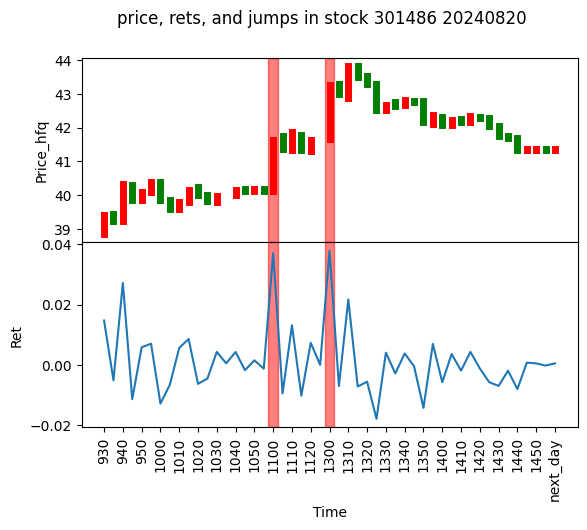

,issue,date,jump,ret_jump
0,301486,2024-08-20,True,0.074808


In [130]:
date = pd.to_datetime('2024-08-20')
date_next = pd.to_datetime('2024-08-21')
# issue = '300556'
issue = '301486'
year = date.year
date_str = date.strftime('%Y%m%d')
price_1m = feather.read_dataframe(f'../data/StockPriceK1m/{year}/StockPriceK1m_{date_str}.feather')
price_1m = price_1m[price_1m['issue'] == issue]

jump_identify_price(price_1m, price_1d, date, date_next, plot=True)

In [10]:
# time_series = price_1d.index.get_level_values('date')
# time_series = time_series.unique().sort_values()
# time_series = time_series[(time_series >= '2020-02-01') & (time_series <= '2020-03-01')]

# issue = '600390'
# os.makedirs(f'../data/check/{issue}/', exist_ok=True)
# tqdm_time_series = tqdm(zip(time_series[:-1],time_series[1:]),
#                         total=len(time_series) - 1, desc='Processing Daily Stocks', unit='days')
# ret_jump = 0.
# for date, date_next in tqdm_time_series:
#     year = date.year
#     date_str = date.strftime('%Y%m%d')
#     price_1m = feather.read_dataframe(f'../data/StockPriceK1m/{year}/StockPriceK1m_{date_str}.feather')
#     price_1m = price_1m[price_1m['issue'] == issue]
#     df_jump = jump_identify_price(price_1m, price_1d, date, date_next, plot=True, figname=f'../data/check/{issue}/{date_str}.png')
#     ret_jump_daily = df_jump.iloc[0]['ret_jump']
#     ret_jump += ret_jump_daily
# ret_jump

## 性能测试

### 单公司单日性能测试

In [11]:
# prc = price_1m.loc[price_1m['issue'] == '000014']
# date = '2024-01-02'
# date_next = '2024-01-03'
# %timeit -n 10 -r 3 jump_identify_price(prc, price_1d, date, date_next)

逐行运行时间

In [12]:
# prc = price_1m.loc[price_1m['issue'] == '000014']
# date = '2024-01-02'
# date_next = '2024-01-03'
# %lprun -f jump_identify_price jump_identify_price(prc, price_1d, date, date_next)

### 单线程 / 并行性能测试

apply 单线程运算

速度: 9.02s / 5096 公司

In [13]:
# %%time
# df_jump = price_1m.groupby('issue')[['issue', 'time', 'open', 'close']].apply(
#     jump_identify_price,
#     price_1d=price_1d,
#     date='2019-01-02',
#     date_next='2019-01-03'
# )

使用 swifter 提速

速度: 6.03s / 5096 公司

In [14]:
# %%time
# df_jump = price_1m.swifter.groupby('issue')[['issue', 'time', 'open', 'close']].apply(
#     jump_identify_price,
#     price_1d=price_1d,
#     date='2019-01-02',
#     date_next='2019-01-03'
# )

使用 joblib 并行运算

速度：18min4s / 5096 公司

In [15]:
# %%time
# df_jump = jump_identify_parallel(price_1m, price_1d, '2024-01-02', '2024-01-03')

## 读入分钟行情, 保存每日股价跳跃信息

In [16]:
time_series = price_1d.index.get_level_values('date')
time_series = time_series.unique().sort_values()
time_series = time_series[(time_series >= '2024-06-28') & (time_series <= '2024-12-31')]
tqdm_time_series = tqdm(zip(time_series[:-1],time_series[1:]),
                        total=len(time_series) - 1, desc='Processing Daily Stocks', unit='days')

for date, date_next in tqdm_time_series:
    year = date.year
    date_str = date.strftime('%Y%m%d')
    price_1m = feather.read_dataframe(f'../data/StockPriceK1m/{year}/StockPriceK1m_{date_str}.feather')
    df_jump = price_1m.groupby('issue')[['issue', 'time', 'open', 'close']].apply(
        jump_identify_price,
        price_1d=price_1d,
        date=date, date_next=date_next
    )
    df_jump = df_jump.reset_index(drop=True)

    os.makedirs(f'../data/jump/{year}/', exist_ok=True)
    feather.write_dataframe(df_jump, f'../data/jump/{year}/jump_{date_str}.feather')

Processing Daily Stocks:   0%|          | 0/125 [00:00<?, ?days/s]

In [17]:
time_series = price_1d.index.get_level_values('date')
time_series = time_series.unique().sort_values()
jump = None
for date in time_series[:-1]:
    year = date.year
    date_str = date.strftime('%Y%m%d')
    jump_daily = feather.read_dataframe(f'../data/jump/{year}/jump_{date_str}.feather')
    jump = pd.concat([jump, jump_daily])
jump = jump[jump['jump']]
jump['year_mon'] = jump['date'].dt.year * 100 + jump['date'].dt.month
jump = jump.sort_values(['issue', 'date'])
jump = jump.reset_index(drop=True)
feather.write_dataframe(jump, '../data/jump/jump.feather')